In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
#from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers

from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import load_model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir digits

In [ ]:
!unzip /content/drive/MyDrive/digits.zip -d "/content/digits"

Streaming output truncated to the last 5000 lines.
  inflating: /content/digits/dataset/Validation/F/167.jpg  
  inflating: /content/digits/dataset/Validation/F/168.jpg  
  inflating: /content/digits/dataset/Validation/F/169.jpg  
  inflating: /content/digits/dataset/Validation/F/17.jpg  
  inflating: /content/digits/dataset/Validation/F/170.jpg  
  inflating: /content/digits/dataset/Validation/F/171.jpg  
  inflating: /content/digits/dataset/Validation/F/172.jpg  
  inflating: /content/digits/dataset/Validation/F/173.jpg  
  inflating: /content/digits/dataset/Validation/F/174.jpg  
  inflating: /content/digits/dataset/Validation/F/175.jpg  
  inflating: /content/digits/dataset/Validation/F/176.jpg  
  inflating: /content/digits/dataset/Validation/F/177.jpg  
  inflating: /content/digits/dataset/Validation/F/178.jpg  
  inflating: /content/digits/dataset/Validation/F/179.jpg  
  inflating: /content/digits/dataset/Validation/F/18.jpg  
  inflating: /content/digits/dataset/Validation/F/1

In [ ]:
dir = "../content/digits/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [ ]:
len(train_data)

140000

In [ ]:
val_dir = "../content/digits/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [ ]:
len(val_data)

15209

In [ ]:
random.shuffle(train_data)
random.shuffle(val_data)

In [ ]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [ ]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [ ]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [ ]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [ ]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [ ]:
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [ ]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [ ]:
# history = model.fit(train_X,train_Y, epochs=100, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

In [ ]:
# model_name = 'digits_recognitionn1.h5'
# model.save(model_name, save_format='h5')


In [ ]:
!cp '/content/drive/MyDrive/digits_recognition_cnn.h5' '/content'

In [ ]:
model= load_model("/content/digits_recognition_cnn.h5")

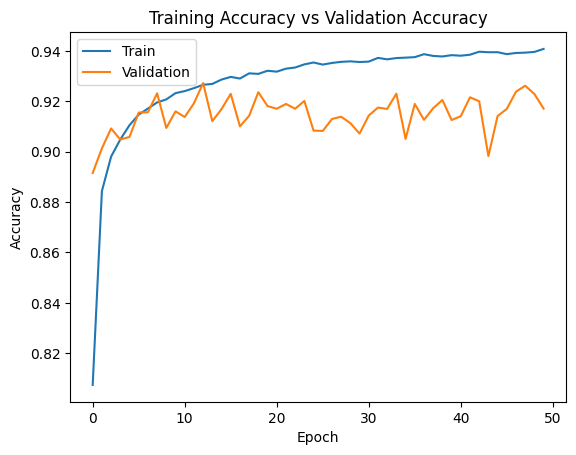

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Training Accuracy vs Validation Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

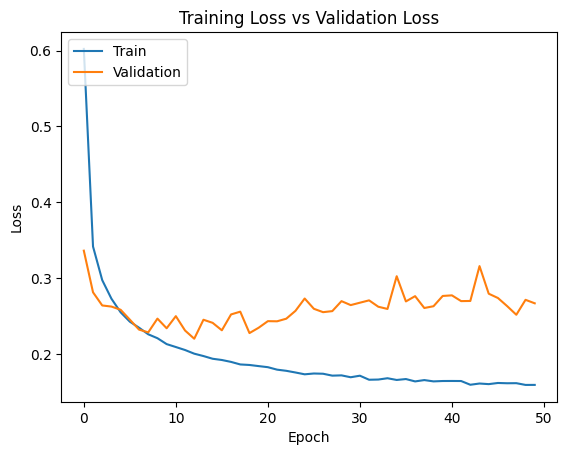

In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Training Loss vs Validation Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# Recognition and Post-Processing


    1)The sort contours function is used to get the correct order of individual characters for correct output extraction. In this case for extracting a single word, a left to right sorting of individual characters is needed.
    2)The get letters function fetches the list of letters and get word function gets the individual word.


In [ ]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [ ]:


def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

In [ ]:
def get_word(letter):
    word = "".join(letter)
    return word

1/1 [==============================] - 0s 68ms/step
SUM0N


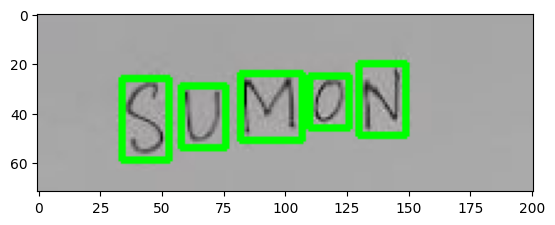

In [ ]:
letter,image = get_letters("../content/su.JPG")
word = get_word(letter)
print(word)
plt.imshow(image)


1/1 [==============================] - 0s 31ms/step
5AYFM


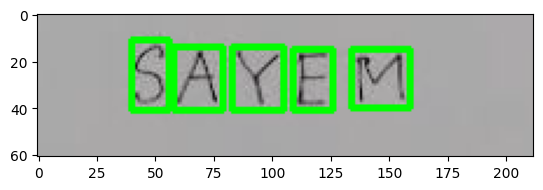

In [ ]:
letter,image = get_letters("../content/sa.JPG")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 63ms/step
LIL0U


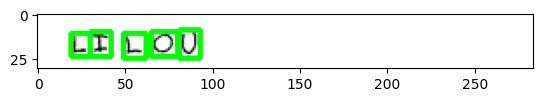

In [ ]:
letter,image = get_letters("../content/TRAIN_00023.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 [==============================] - 0s 39ms/step
BEWE5


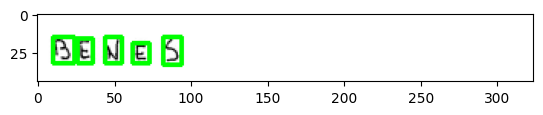

In [ ]:
letter,image = get_letters("../content/TRAIN_00003.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)


# Drawbacks

   1) The recognition part is dependent on the contour detection code, so if the opencv library is not able to find the character contour, then this method will fail.
   2)There could be a lot of variation in a single handwritten letter in terms of writing style, therefore a lot more examples are needed for training this model.
   3)This model will not work for connected texts like a cursive handwritten word.

